In [1]:
from torch import nn
import torch

In [2]:
from torch.nn.utils.rnn import pad_sequence

In [3]:
import numpy as np

In [4]:
import pandas as pd

In [5]:
import os

In [6]:
from einops import rearrange

In [7]:
import random

In [8]:
from torch.utils.data import DataLoader

In [9]:
import torchvision.transforms as T

In [10]:
from skimage.util import random_noise

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [12]:
import torchaudio

C:\Users\aag12\anaconda3\envs\ml_env\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [13]:
from sklearn import preprocessing

In [14]:
from sklearn.model_selection import train_test_split

# Defining Dataseat

In [15]:
class MusicDataset(torch.utils.data.Dataset):   
    def __init__(self, np_file_paths, labels, seq_len=10000, random_start=True, noise=True):
        self.seq_len = seq_len
        self.files = np_file_paths
        self.padder = torch.zeros(96, seq_len)
        self.labels = labels
        self.noise = noise
        self.random_start = random_start
#         self.labels = []
#         for i in range(len(self.files)):
#             label = np.random.randint(0, 10, size=15)
#             label[label > 8] = 0
#             label[label >= 1] = 1
#             self.labels.append(label)
#         for i in range(len(self.files)):
#             label = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
#             self.labels.append(label)
    def __len__(self):
        return len(self.files)

#     def __getitem__(self, index):
#         return (self.X[index:index+self.seq_len], self.y[index+self.seq_len-1])
    def __getitem__(self, index):
        x = np.load(self.files[index])
        x = torch.from_numpy(x).float()
#         print(x.shape)
        if self.random_start and x.shape[-1] > self.seq_len:
            # longer than 3000, select random subset
            start = random.randint(0, x.shape[-1] - self.seq_len)
            x = x[:,start:start+self.seq_len]
        else:
            x = x[:,:self.seq_len]
        x = pad_sequence([x.T, self.padder.T], padding_value=-90, batch_first=True)[0].T
        x = x.unsqueeze(0)
        x = x.permute(0, 2, 1)

        if self.noise:
#             x = torch.tensor(random_noise(x, mode='gaussian', mean=0, var=0.05, clip=False)).float()
            x = torch.tensor(random_noise(x, mode='gaussian', mean=0, var=0.1, clip=False)).float()
#         input,label_ids,label
        item = {"input": x, "label_ids":[index], "labels": torch.tensor(self.labels[index])}
        return item
#         return x

In [16]:
from datasets import load_dataset

In [17]:
from datasets import disable_caching
disable_caching()

In [18]:
# good_files = []
# for i in range(1, 6):
#     new_files = [f"0{i}/{fname.replace('npy', '')}mp3" for fname in os.listdir(f"../../subset_moodtheme/0{i}")]
#     good_files.extend(new_files)

# test_files = [f"00/{fname.replace('npy', '')}mp3" for fname in os.listdir("../../subset_moodtheme/00")]
# print(good_files)
# print(test_files)

In [19]:
with open("goodfiles.txt", 'r') as f:
    all_files = f.readlines()
all_files = [g.strip().replace("npy", 'mp3') for g in all_files if len(g.strip()) > 0]

In [20]:
all_files[:3]

['01/846501.mp3', '34/1288334.mp3', '98/1082098.mp3']

In [21]:
good_files, test_files = train_test_split(all_files, test_size=0.2)

In [22]:
len(good_files), len(test_files)

(2200, 551)

In [23]:
def files_to_labels(files):
    col_names = ['TRACK_ID',
     'ARTIST_ID',
     'ALBUM_ID',
     'PATH',
     'DURATION',
     'TAGS',
     'TAGS2',
     'TAGS3',
     'TAGS4',
     'TAGS5',
     'TAGS6',
     'TAGS7',
     'TAGS8',
     'TAGS9']
    MOODPATH = "../../../Downloads/autotagging_moodtheme.tsv.txt"
    df = pd.read_csv(MOODPATH, sep='\t', names=col_names)
    df = df[df["PATH"].isin(files)]
    inds = {'fast': 0,
     'sexy': 1,
     'mellow': 2,
     'heavy': 3,
     'horror': 4,
     'travel': 5,
     'holiday': 6,
     'groovy': 7,
     'funny': 8,
     'retro': 9,
     'hopeful': 10,
     'powerful': 11,
     'cool': 12,
     'nature': 13,
     'game': 14}

    final_labels = []
    for i in range(len(df)):
        curr = np.zeros(len(inds))
        moods = list(df.iloc[i])[5:]
        for theme in moods:
            if type(theme) == str and "mood" in theme:
                check = theme.split("---")[-1]
                if check in inds:
                    curr[inds[check]] = 1
            else:
                pass

        final_labels.append(curr)
    return final_labels

In [24]:
train_labels = files_to_labels(good_files)

In [25]:
test_labels = files_to_labels(test_files)

In [26]:
train_labels[:2]

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])]

In [27]:
# train_np_files = [("../../subset_moodtheme/" + g).replace(".mp3", ".npy") for g in good_files]
# test_np_files = [("../../subset_moodtheme/" + g).replace(".mp3", ".npy") for g in test_files]
train_np_files = ["../../mtg-jamendo-dataset/all_data/" + g.replace("mp3", "npy") for g in good_files]
test_np_files = ["../../mtg-jamendo-dataset/all_data/" + g.replace("mp3", "npy") for g in test_files]

In [28]:
train_np_files[:2], test_np_files[:2]

(['../../mtg-jamendo-dataset/all_data/49/1045249.npy',
  '../../mtg-jamendo-dataset/all_data/45/1113645.npy'],
 ['../../mtg-jamendo-dataset/all_data/33/1359333.npy',
  '../../mtg-jamendo-dataset/all_data/24/1222824.npy'])

In [29]:
import time

In [30]:
# SEQ_LEN = 10000
SEQ_LEN = 3000
# SEQ_LEN = 5000

In [31]:
train_dataset = MusicDataset(train_np_files, train_labels, seq_len=SEQ_LEN, noise=True, random_start=True)
test_dataset = MusicDataset(test_np_files, test_labels, seq_len=SEQ_LEN, noise=False, random_start=True)

# MODEL TESTING
run dataset stuff first

In [42]:
from torchvision import transforms

In [ ]:
from transformers import ViTConfig, ViTModel

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [45]:
batch_size=16

In [46]:
configuration = ViTConfig()

In [47]:
configuration.image_size

224

In [48]:
configuration.num_channels = 1
# configuration.image_size = 225

In [49]:
model = ViTModel(configuration)

In [50]:
model.config

ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 1,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.23.1"
}

In [51]:
inp = train_dataset[0]['input']
start_data = inp.unsqueeze(0)

In [52]:
tr = transforms.Resize((224, 224))

In [53]:
res = tr(inp)

In [54]:
res.shape

torch.Size([1, 224, 224])

In [55]:
import matplotlib.pyplot as plt

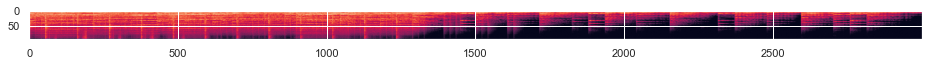

In [56]:
plt.figure(figsize=(16, 6))
plt.imshow(inp[0].permute(1, 0))

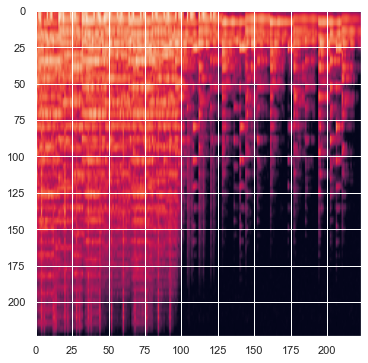

In [57]:
plt.figure(figsize=(16, 6))
plt.imshow(res[0].permute(1, 0))

In [58]:
res[0].shape

torch.Size([224, 224])

In [59]:
res

tensor([[[ -5.0495,  -3.9592,  -0.6885,  ..., -84.4419, -88.8425, -90.3093],
         [-35.6501, -35.0531, -33.2622,  ..., -87.1897, -89.1975, -89.8668],
         [-10.2010,  -9.3612,  -6.8418,  ..., -82.8060, -84.8585, -85.5426],
         ...,
         [-73.3483, -69.6051, -58.3754,  ..., -90.2603, -90.3009, -90.3144],
         [-75.9351, -72.1995, -60.9925,  ..., -89.7647, -89.9710, -90.0398],
         [-77.7232, -74.3543, -64.2475,  ..., -89.8924, -89.9706, -89.9967]]])

In [60]:
inp

tensor([[[-30.9667, -31.5189, -26.1063,  ..., -60.0523, -75.6249, -90.0798],
         [-14.4872,  -8.9839,  -8.3938,  ..., -51.6175, -58.1785, -70.4256],
         [ -8.8643,  -6.9824,  -0.3497,  ..., -57.1014, -74.2113, -85.4595],
         ...,
         [-72.7853, -51.2411, -40.7030,  ..., -90.3196, -90.2025, -90.3611],
         [-73.4438, -50.5015, -39.5264,  ..., -89.7515, -90.3158, -89.8375],
         [-70.9137, -50.7764, -39.7551,  ..., -89.8172, -89.2611, -90.2712]]])

In [61]:
inp.shape

torch.Size([1, 3000, 96])

In [62]:
start_data.reshape

<function Tensor.reshape>

In [63]:
res.shape

torch.Size([1, 224, 224])

In [64]:
model = model.to(device)

In [65]:
go = res.unsqueeze(0).to(device)

In [134]:
# model(go)

## MAE

In [436]:
from vit_pytorch import ViT, MAE

In [437]:
class MusicDataset(torch.utils.data.Dataset):   
    def __init__(self, np_file_paths, labels, transforms, seq_len=10000):
        self.seq_len = seq_len
        self.files = np_file_paths
        self.transforms = transforms
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        x = np.load(self.files[index])
        x = torch.from_numpy(x).float()
        x = x[:,:self.seq_len]
        x = x.unsqueeze(0)
        x = self.transforms(x)
#         item = {"input": x, "label_ids":[index], "labels": torch.tensor(self.labels[index])}
#         return item
        return x

In [438]:
composed = transforms.Compose([
   transforms.Resize((224, 224)),
])

In [187]:
composed(res).shape

torch.Size([1, 224, 224])

In [188]:
train_dataset = MusicDataset(train_np_files, train_labels, composed, seq_len=SEQ_LEN)
test_dataset = MusicDataset(test_np_files, test_labels, composed, seq_len=SEQ_LEN)

In [189]:
batch_size = 8

In [190]:
train_dl = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )

test_dl = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )

In [249]:
v = ViT(
    image_size = 224,
#     patch_size = 32,
    patch_size = 16,
    num_classes = 15,
#     dim = 1024,
    dim = 512,
    depth = 6,
    heads = 8,
#     mlp_dim = 2048,
    mlp_dim = 512,
    channels=1
)
mae = MAE(
    encoder = v,
    masking_ratio = 0.75,   # the paper recommended 75% masked patches
    decoder_dim = 512,      # paper showed good results with just 512
    decoder_depth = 6       # anywhere from 1 to 8
)

In [251]:
from tqdm import tqdm
import torch.optim as optim

In [252]:
mae = mae.to(DEVICE)

In [253]:
data.shape

torch.Size([8, 1, 224, 224])

In [254]:
def get_total_loss(model, dataloader):
    total_loss = 0
    for batch_idx, data in enumerate(dataloader):
        loss = mae(data.to(device))
        total_loss += loss.item()
    return total_loss

In [255]:
# optimizer = optim.AdamW(mae.parameters(), lr=1e-2)
# optimizer = optim.AdamW(mae.parameters(), lr=5e-2, weight_decay=0.05, betas=(0.9, 0.95))
optimizer = optim.AdamW(mae.parameters(), lr=5e-3, weight_decay=0.05, betas=(0.9, 0.95))

In [256]:
train_losses = []
test_losses = []
for epoch in range(100):
    total_loss = 0
    for batch_idx, data in tqdm(enumerate(train_dl), total=len(train_dl)):
        optimizer.zero_grad()
        
        loss = mae(data.to(device))
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    with torch.no_grad():
        test_loss = get_total_loss(model, test_dl)
        train_losses.append(total_loss)
        test_losses.append(test_loss)
        print(f"Epoch: {epoch}; Loss: {total_loss}; Test Loss: {test_loss}")
    if test_loss == min(test_losses):
        torch.save(v.state_dict(), f"./trained-vit-{epoch}.pt")

_ = mae.eval()

100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:25<00:00, 10.84it/s]


Epoch: 0; Loss: 276080.3042449951; Test Loss: 246350.5579147339


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:25<00:00, 10.83it/s]


Epoch: 1; Loss: 89291.69067382812; Test Loss: 140533.61388397217


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.78it/s]


Epoch: 2; Loss: 54749.39376068115; Test Loss: 96360.1615486145


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.81it/s]


Epoch: 3; Loss: 48744.62087249756; Test Loss: 83770.93311691284


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.63it/s]


Epoch: 4; Loss: 43921.656311035156; Test Loss: 78264.68698692322


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.33it/s]


Epoch: 5; Loss: 40744.013359069824; Test Loss: 81621.57325744629


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.77it/s]


Epoch: 6; Loss: 38521.14498138428; Test Loss: 76112.8122215271


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.79it/s]


Epoch: 7; Loss: 39314.981216430664; Test Loss: 78907.4281539917


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.20it/s]


Epoch: 8; Loss: 37101.98306274414; Test Loss: 72873.41133499146


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.54it/s]


Epoch: 9; Loss: 37447.97604370117; Test Loss: 74116.89520454407


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.77it/s]


Epoch: 10; Loss: 38564.417976379395; Test Loss: 71480.00602912903


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.77it/s]


Epoch: 11; Loss: 37344.94650268555; Test Loss: 69573.21865081787


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:25<00:00, 10.96it/s]


Epoch: 12; Loss: 35259.97687149048; Test Loss: 68291.31255722046


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.77it/s]


Epoch: 13; Loss: 34774.32368469238; Test Loss: 70128.72945213318


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.77it/s]


Epoch: 14; Loss: 34367.07344055176; Test Loss: 64517.289363861084


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.79it/s]


Epoch: 15; Loss: 34087.94969558716; Test Loss: 64260.59979057312


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.01it/s]


Epoch: 16; Loss: 39253.41689300537; Test Loss: 63982.686040878296


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.79it/s]


Epoch: 17; Loss: 33696.09609222412; Test Loss: 64116.94851875305


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.80it/s]


Epoch: 18; Loss: 33439.7018737793; Test Loss: 62960.07576942444


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.45it/s]


Epoch: 19; Loss: 33231.4119720459; Test Loss: 63414.529989242554


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.41it/s]


Epoch: 20; Loss: 33528.21862792969; Test Loss: 64198.66967201233


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.77it/s]


Epoch: 21; Loss: 33123.91159057617; Test Loss: 62405.891607284546


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.74it/s]


Epoch: 22; Loss: 32624.351928710938; Test Loss: 62492.674715042114


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.11it/s]


Epoch: 23; Loss: 32692.774353027344; Test Loss: 62482.71595954895


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.78it/s]


Epoch: 24; Loss: 32527.833568572998; Test Loss: 64123.42633628845


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.83it/s]


Epoch: 25; Loss: 32729.608673095703; Test Loss: 64575.148067474365


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.79it/s]


Epoch: 26; Loss: 32585.535484313965; Test Loss: 64037.85218048096


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:25<00:00, 10.92it/s]


Epoch: 27; Loss: 32540.621856689453; Test Loss: 58861.048990249634


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.78it/s]


Epoch: 28; Loss: 32262.860801696777; Test Loss: 62310.73246002197


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.76it/s]


Epoch: 29; Loss: 32077.321975708008; Test Loss: 61365.99906539917


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.62it/s]


Epoch: 30; Loss: 32290.115825653076; Test Loss: 62180.878032684326


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:32<00:00,  8.54it/s]


Epoch: 31; Loss: 31770.214351654053; Test Loss: 63384.885791778564


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:25<00:00, 10.89it/s]


Epoch: 32; Loss: 32172.485313415527; Test Loss: 67790.1958732605


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.76it/s]


Epoch: 33; Loss: 32014.1664352417; Test Loss: 62485.85102844238


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:25<00:00, 10.95it/s]


Epoch: 34; Loss: 31977.01109313965; Test Loss: 62845.21714782715


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.73it/s]


Epoch: 35; Loss: 32266.510864257812; Test Loss: 62610.413579940796


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.75it/s]


Epoch: 36; Loss: 31842.93252182007; Test Loss: 60536.518907547


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.64it/s]


Epoch: 37; Loss: 32036.33642578125; Test Loss: 69159.2629070282


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.28it/s]


Epoch: 38; Loss: 31939.500198364258; Test Loss: 61691.8097076416


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.77it/s]


Epoch: 39; Loss: 31813.528816223145; Test Loss: 63400.95610618591


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.82it/s]


Epoch: 40; Loss: 31659.230533599854; Test Loss: 64084.54666137695


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.52it/s]


Epoch: 41; Loss: 31789.322193145752; Test Loss: 63040.64032936096


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.45it/s]


Epoch: 42; Loss: 31776.0304107666; Test Loss: 62634.44348335266


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.80it/s]


Epoch: 43; Loss: 31546.23041152954; Test Loss: 60606.60872268677


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.82it/s]


Epoch: 44; Loss: 31711.528747558594; Test Loss: 61192.1139755249


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.15it/s]


Epoch: 45; Loss: 31438.24723815918; Test Loss: 62366.50410270691


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.80it/s]


Epoch: 46; Loss: 31485.332569122314; Test Loss: 59283.84027290344


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.79it/s]


Epoch: 47; Loss: 31516.596271514893; Test Loss: 60040.50053024292


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.81it/s]


Epoch: 48; Loss: 31627.313526153564; Test Loss: 59621.68665885925


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.20it/s]


Epoch: 49; Loss: 31377.757362365723; Test Loss: 59619.49256324768


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.80it/s]


Epoch: 50; Loss: 31536.31558227539; Test Loss: 59540.72929382324


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.80it/s]


Epoch: 51; Loss: 31206.057327270508; Test Loss: 61438.022062301636


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.70it/s]


Epoch: 52; Loss: 31353.19784927368; Test Loss: 58263.9245929718


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.28it/s]


Epoch: 53; Loss: 31330.62195968628; Test Loss: 58904.20904922485


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.82it/s]


Epoch: 54; Loss: 31120.392684936523; Test Loss: 60504.27367019653


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.79it/s]


Epoch: 55; Loss: 31487.384742736816; Test Loss: 71139.6710472107


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.53it/s]


Epoch: 56; Loss: 31281.676010131836; Test Loss: 62416.58356285095


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.54it/s]


Epoch: 57; Loss: 31330.523864746094; Test Loss: 65686.55772399902


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.80it/s]


Epoch: 58; Loss: 31054.891708374023; Test Loss: 62164.995641708374


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.83it/s]


Epoch: 59; Loss: 31307.556316375732; Test Loss: 64342.106439590454


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.03it/s]


Epoch: 60; Loss: 31212.03783416748; Test Loss: 60124.2713470459


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.71it/s]


Epoch: 61; Loss: 31233.347076416016; Test Loss: 59062.84935760498


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.78it/s]


Epoch: 62; Loss: 31084.09398651123; Test Loss: 60232.30786895752


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.78it/s]


Epoch: 63; Loss: 31249.912872314453; Test Loss: 60855.75570678711


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:25<00:00, 11.00it/s]


Epoch: 64; Loss: 31176.66524887085; Test Loss: 59502.97692871094


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.71it/s]


Epoch: 65; Loss: 31194.1668510437; Test Loss: 61483.98736000061


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.75it/s]


Epoch: 66; Loss: 31039.03722000122; Test Loss: 59375.24447631836


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.46it/s]


Epoch: 67; Loss: 30878.195476531982; Test Loss: 58671.19668006897


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.33it/s]


Epoch: 68; Loss: 31101.62539291382; Test Loss: 59497.98830413818


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.76it/s]


Epoch: 69; Loss: 31255.86809539795; Test Loss: 57928.4369392395


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.74it/s]


Epoch: 70; Loss: 30859.056114196777; Test Loss: 58360.06322669983


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.25it/s]


Epoch: 71; Loss: 30945.903812408447; Test Loss: 59921.462911605835


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.69it/s]


Epoch: 72; Loss: 31021.851440429688; Test Loss: 60211.430028915405


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.73it/s]


Epoch: 73; Loss: 30954.92714691162; Test Loss: 60183.2161655426


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.80it/s]


Epoch: 74; Loss: 31194.60179901123; Test Loss: 60798.046617507935


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:25<00:00, 10.83it/s]


Epoch: 75; Loss: 31070.525840759277; Test Loss: 59354.38853645325


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.73it/s]


Epoch: 76; Loss: 31174.45948791504; Test Loss: 69144.55572891235


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.70it/s]


Epoch: 77; Loss: 30934.80707168579; Test Loss: 59280.320837020874


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.72it/s]


Epoch: 78; Loss: 30928.584762573242; Test Loss: 61938.89379310608


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.07it/s]


Epoch: 79; Loss: 30884.75291824341; Test Loss: 59649.7091255188


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.82it/s]


Epoch: 80; Loss: 31047.251041412354; Test Loss: 63060.00495529175


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.75it/s]


Epoch: 81; Loss: 30755.207469940186; Test Loss: 59032.56268310547


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.49it/s]


Epoch: 82; Loss: 30642.4167137146; Test Loss: 59811.915309906006


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.53it/s]


Epoch: 83; Loss: 31015.34331893921; Test Loss: 59629.43381690979


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.74it/s]


Epoch: 84; Loss: 30912.756088256836; Test Loss: 61631.67461967468


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.71it/s]


Epoch: 85; Loss: 30863.185497283936; Test Loss: 61497.50419807434


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.02it/s]


Epoch: 86; Loss: 31043.876613616943; Test Loss: 60640.17737197876


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.75it/s]


Epoch: 87; Loss: 30665.318630218506; Test Loss: 59728.285568237305


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.75it/s]


Epoch: 88; Loss: 31147.4487991333; Test Loss: 58179.90757369995


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.76it/s]


Epoch: 89; Loss: 30914.44522857666; Test Loss: 60071.09903717041


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:25<00:00, 10.92it/s]


Epoch: 90; Loss: 30964.728981018066; Test Loss: 58520.20722961426


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.73it/s]


Epoch: 91; Loss: 30785.10216140747; Test Loss: 58938.9517288208


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.76it/s]


Epoch: 92; Loss: 31053.523887634277; Test Loss: 60718.51557159424


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.54it/s]


Epoch: 93; Loss: 30698.90421295166; Test Loss: 66016.17458724976


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.22it/s]


Epoch: 94; Loss: 30831.16035079956; Test Loss: 58507.77581214905


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.76it/s]


Epoch: 95; Loss: 30737.15912628174; Test Loss: 65662.72535133362


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.78it/s]


Epoch: 96; Loss: 31069.696098327637; Test Loss: 58491.41403198242


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.22it/s]


Epoch: 97; Loss: 30868.474266052246; Test Loss: 63202.20079994202


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.54it/s]


Epoch: 98; Loss: 30767.019939422607; Test Loss: 59759.9649105072


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.74it/s]


Epoch: 99; Loss: 31040.607460021973; Test Loss: 58119.37052536011


In [269]:
# torch.save(v.state_dict(), f"./lastnotbest-trained-vit-{epoch}.pt")
torch.save(mae.state_dict(), f"./maeklastnotbest-trained-vit-{epoch}.pt")

In [257]:
30 * 800 / 60 / 60

6.666666666666667

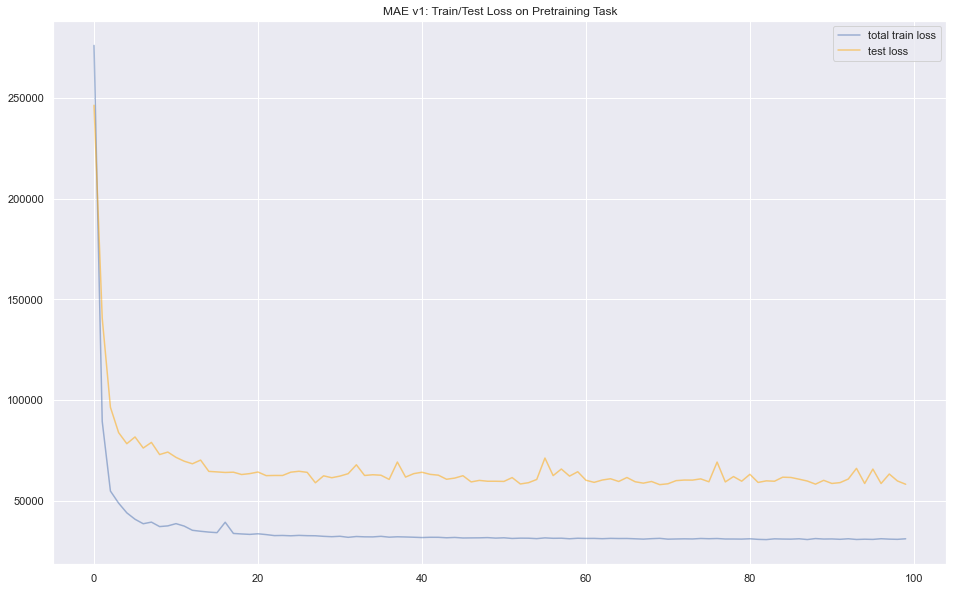

In [272]:
plt.figure(figsize=(16, 10))
ranger = list(range(len(train_losses)))
sns.lineplot(x=ranger, y=train_losses, label="total train loss", alpha=0.5)
# sns.lineplot(x=ranger, y=adjusted_train_losses, label="adjusted train loss")
# ax2 = plt.twinx()
# sns.lineplot(x=ranger, y=test_losses, label="test loss", ax=ax2, color="orange", alpha=0.5)
sns.lineplot(x=ranger, y=test_losses, label="test loss", color="orange", alpha=0.5)
plt.title("MAE v1: Train/Test Loss on Pretraining Task")
plt.savefig("mae_v1.png")

# Finetuning MAE for Task

In [439]:
class FinetuningMusicDataset(torch.utils.data.Dataset):   
    def __init__(self, np_file_paths, labels, transforms, seq_len=10000, random_start=True):
        self.seq_len = seq_len
        self.files = np_file_paths
        self.labels = labels
        self.transforms = transforms
        self.random_start = random_start
    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        x = np.load(self.files[index])
        x = torch.from_numpy(x).float()
        if self.random_start and x.shape[-1] > self.seq_len:
            # longer than 3000, select random subset
            start = random.randint(0, x.shape[-1] - self.seq_len)
            x = x[:,start:start+self.seq_len]
        else:
            x = x[:,:self.seq_len]
        x = x.unsqueeze(0)
        x = self.transforms(x)
        item = {"input": x, "label_ids":[index], "labels": torch.tensor(self.labels[index])}
        
        return item

In [440]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [441]:
composed = transforms.Compose([
   transforms.Resize((224, 224)),
    AddGaussianNoise(0., 1.)
])

In [442]:
composed(inp).shape

torch.Size([1, 224, 224])

In [443]:
res.shape

torch.Size([1, 224, 224])

In [444]:
ft_train_dataset = FinetuningMusicDataset(train_np_files, train_labels, composed, seq_len=SEQ_LEN, random_start=True)
ft_test_dataset = FinetuningMusicDataset(test_np_files, test_labels, composed, seq_len=SEQ_LEN, random_start=False)

In [445]:
ft_train_dl = DataLoader(
    ft_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )

ft_test_dl = DataLoader(
    ft_test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )

In [470]:
from transformers import ViTConfig, ViTModel
from vit_pytorch import ViT, MAE

In [471]:
v_for_downstream = ViT(
    image_size = 224,
#     patch_size = 32,
    patch_size = 16,
    num_classes = 15,
#     dim = 1024,
    dim = 512,
    depth = 6,
    heads = 8,
#     mlp_dim = 2048,
    mlp_dim = 512,
    channels=1
)

In [472]:
v_for_downstream.load_state_dict(torch.load(f"./trained-vit-69.pt"))

<All keys matched successfully>

In [473]:
v_for_downstream.mlp_head

Sequential(
  (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (1): Linear(in_features=512, out_features=15, bias=True)
)

In [476]:
def freeze_all_layers_(module):
    set_module_requires_grad_(module, False)

In [477]:
freeze_all_layers_(v_for_downstream)

In [478]:
new_head = nn.Sequential(
    nn.LayerNorm(512),
    nn.Linear(512, 512),
    nn.Linear(512, 15),
#     nn.Sigmoid()
)

In [479]:
v_for_downstream.mlp_head = new_head

In [480]:
# model = nn.Sequential(
#     v_for_downstream,
#     nn.Sigmoid()
# )

In [481]:
v_for_downstream.to(device)(go)

tensor([[ 0.1323,  0.4026,  0.5004,  0.1784,  0.2461,  0.3171,  0.0979, -0.0043,
         -0.0513, -0.0998, -0.1268, -0.1027,  0.1976,  0.0807, -0.2799]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [482]:
model = v_for_downstream.to(device)

In [483]:
from tqdm import tqdm
import torch.optim as optim

In [338]:
pos_weight = torch.ones([15]) * (14/1)

In [340]:
model.parameters()

<generator object Module.parameters at 0x0000013A7AB32740>

In [341]:
model.mlp_head.parameters()

<generator object Module.parameters at 0x0000013A7AB32B30>

In [342]:
# optimizer = optim.AdamW(model.parameters(), lr=1e-3)
# optimizer = optim.AdamW(model.parameters(), lr=1e-4)
optimizer = optim.AdamW(model.mlp_head.parameters(), lr=1e-3)
# criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight.to(device))

In [343]:
def get_mask(targs):
    mask = []
    for val in targs:
        m = int(val) == 1 or random.random() < (1/15)
        mask.append(m)
    return mask

In [344]:
def get_total_loss(model, dataloader):
    total_loss = 0
    for batch_idx, data in enumerate(dataloader):
        inputs, labels = data['input'].to(device), data['labels'].to(device)

        outputs = model(inputs)
        total_loss += criterion(outputs, labels.float())
#         for i in range(15):
#             cur_loss = criterion(outputs[:,i], labels[:,i].float())
#             total_loss += cur_loss
    return total_loss.item()

In [345]:
model.train()
ft_train_losses = []
ft_adjusted_train_losses = []
ft_test_losses = []
for epoch in range(30):
# for epoch in range(5):
    total_loss = 0
#     for batch in train_loader:
    for batch_idx, data in tqdm(enumerate(ft_train_dl), total=len(ft_train_dl)):
        these_losses = []
        optimizer.zero_grad()
        inputs, labels = data['input'].to(device), data['labels'].to(device)
        outputs = model(inputs)
        
#         for i in range(15):
#             preds = outputs[:,i]
#             targs = labels[:,i].float()
#             mask = get_mask(targs)
#             if sum(mask) == 0:
#                 continue
#             cur_loss = criterion(preds[mask], targs[mask])
#             these_losses.append(cur_loss)
        loss = criterion(outputs, labels)
#         loss = sum(these_losses)
        loss.backward()
        optimizer.step()
        # for bookkeeping
        total_loss += loss.item()
#     total_loss.backward()
        
#     total_loss += loss.item()
#         break
    with torch.no_grad():
        train_total_loss = get_total_loss(model, ft_train_dl)
        test_loss = get_total_loss(model, ft_test_dl)
        adjusted = total_loss
        ft_train_losses.append(train_total_loss)
        ft_adjusted_train_losses.append(adjusted)
        ft_test_losses.append(test_loss)
        print(f"Epoch: {epoch}; Loss: {adjusted}; Total Loss: {train_total_loss}; Test Loss: {test_loss}")
#         print(f"Epoch: {epoch}; Loss: {adjusted}; Test Loss: {test_loss}")

_ = model.eval()

100%|████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:18<00:00,  7.40it/s]


Epoch: 0; Loss: 193.64051289964294; Total Loss: 183.9403839111328; Test Loss: 735.5714111328125


100%|████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:18<00:00,  7.40it/s]


Epoch: 1; Loss: 184.96196274337888; Total Loss: 183.86923217773438; Test Loss: 743.2202758789062


100%|████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:18<00:00,  7.47it/s]


Epoch: 2; Loss: 184.63577871976426; Total Loss: 181.49673461914062; Test Loss: 730.5820922851562


100%|████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:18<00:00,  7.63it/s]


Epoch: 3; Loss: 182.39256543158655; Total Loss: 180.75967407226562; Test Loss: 734.1642456054688


 20%|█████████████████▍                                                                       | 27/138 [00:02<00:10, 11.06it/s]


KeyboardInterrupt: 

Text(0.5, 1.0, 'MAE v1: Finetuning Train/Test Loss')

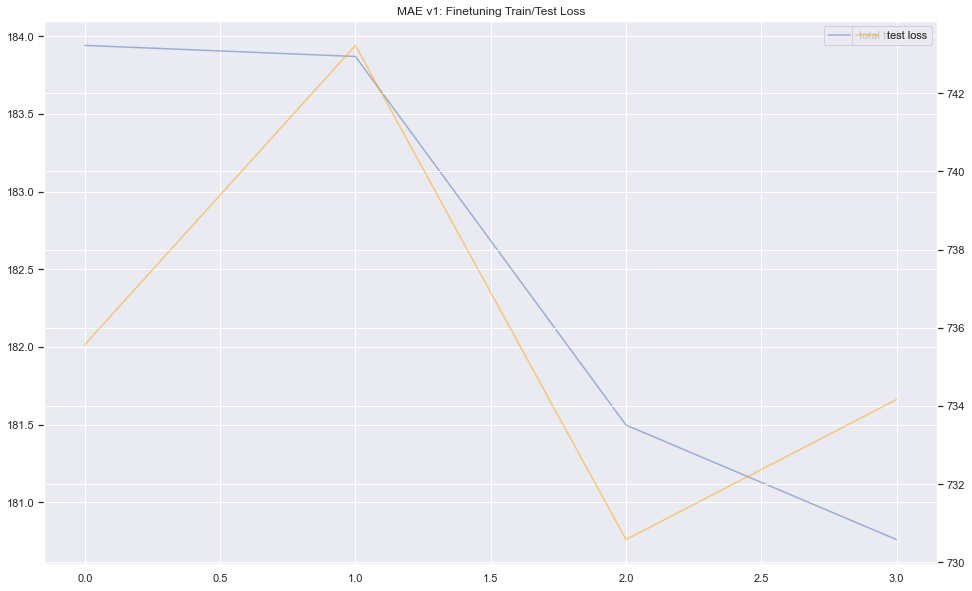

In [346]:
plt.figure(figsize=(16, 10))
ranger = list(range(len(ft_train_losses)))
sns.lineplot(x=ranger, y=ft_train_losses, label="total train loss", alpha=0.5)
# sns.lineplot(x=ranger, y=adjusted_train_losses, label="adjusted train loss")
ax2 = plt.twinx()
sns.lineplot(x=ranger, y=ft_test_losses, label="test loss", ax=ax2, color="orange", alpha=0.5)
# sns.lineplot(x=ranger, y=ft_test_losses, label="test loss", color="orange", alpha=0.5)
plt.title("MAE v1: Finetuning Train/Test Loss")
# plt.savefig("mae_v1.png")

In [347]:
outlabels = torch.zeros_like(outputs)
outlabels[outputs >= 0.5] = 1
outlabels[outputs < 0.5] = 0

In [348]:
outlabels[outputs >= 0.5] = 1
outlabels[outputs < 0.5] = 0

In [349]:
outlabels[labels == 0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 1.], device=

In [350]:
torch.sum(labels[labels == 1] == outlabels[labels == 1])

tensor(4, device='cuda:0')

In [351]:
torch.sum(outlabels == labels).item()

191

In [352]:
len(labels)

16

In [353]:
torch.sum(labels == 0).item()

222

In [354]:
torch.cat([outputs, outputs, outputs])

tensor([[-0.8299, -0.2612, -0.2822, -0.3571, -0.3948, -0.0981, -0.5346,  0.4613,
          0.4093, -0.0538,  0.3403,  0.3392,  0.4884,  0.6145,  0.5564],
        [-0.7982, -0.2667, -0.1813, -0.2258, -0.3268, -0.0038, -0.5952,  0.4399,
          0.4783,  0.0319,  0.2845,  0.3417,  0.4716,  0.6028,  0.4156],
        [-0.9988, -0.2365, -0.3270, -0.4576, -0.5811, -0.0347, -0.6686,  0.5655,
          0.5392, -0.1087,  0.3228,  0.4451,  0.4694,  0.6260,  0.7232],
        [-0.6630, -0.2703, -0.1805, -0.1333, -0.2849, -0.0863, -0.5208,  0.4534,
          0.3722, -0.0057,  0.3443,  0.2164,  0.4787,  0.5870,  0.3873],
        [-0.6273, -0.3323, -0.2319, -0.1485, -0.3330, -0.2155, -0.4367,  0.4873,
          0.2954, -0.1014,  0.4146,  0.1876,  0.5325,  0.6257,  0.5198],
        [-0.8723, -0.2532, -0.2395, -0.3088, -0.4125, -0.0170, -0.5872,  0.4872,
          0.4680,  0.0042,  0.3006,  0.3491,  0.4554,  0.6207,  0.5204],
        [-0.7530, -0.2917, -0.3180, -0.3798, -0.3719, -0.2195, -0.4368,  0.4

In [355]:
model.eval()

combined_preds = []
combined_labels = []

with torch.no_grad():
#     a = model(dataset[2]['input'].to(device))
    total_correct = 0
    zero_correct = 0
    total_values = 0
    only_positives = [0, 0]
    for batch_idx, data in enumerate(ft_test_dl):
        inputs, labels = data['input'].to(device), data['labels'].to(device)

        outputs = model(inputs)
        combined_preds.append(outputs)
        combined_labels.append(labels)
        
        outlabels = torch.zeros_like(outputs)
        outlabels[outputs >= 0.5] = 1
        outlabels[outputs < 0.5] = 0
        
        num_correct = torch.sum(outlabels == labels).item()
        num = len(labels) * 15
        
        total_correct += num_correct
        total_values += num
        zero_correct += torch.sum(labels == 0).item()
        
        only_positives[0] += torch.sum(labels).item()
        only_positives[1] += torch.sum(labels[labels == 1] == outlabels[labels == 1]).item()
        

print(total_correct / total_values)

print(f"{total_correct} out of {total_values}")

print("Performance on positive labels")

print(only_positives[1] / only_positives[0])

print(f"{only_positives[1]} out of {only_positives[0]}")

print("WHAT IF WE JUST PREDICTED ZERO")

print(zero_correct / total_values)

print(f"{zero_correct} out of {total_values}")

0.8220205686630369
6794 out of 8265
Performance on positive labels
0.1621160409556314
95 out of 586.0
WHAT IF WE JUST PREDICTED ZERO
0.9290986085904416
7679 out of 8265


In [356]:
all_preds = torch.cat(combined_preds)
all_labels = torch.cat(combined_labels)
all_preds.shape, all_labels.shape

(torch.Size([551, 15]), torch.Size([551, 15]))

In [357]:
len(ft_test_dataset)

551

In [358]:
from sklearn import metrics

In [359]:
for i in range(15):
    preds = all_preds[:,i].cpu()
    targs = all_labels[:,i].cpu()
#     fpr, tpr, thresholds = metrics.roc_curve(targs, preds, pos_label=1)
    fpr, tpr, thresholds = metrics.roc_curve(targs, preds, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    print(f"Head: {i}; AUC: {auc}")

Head: 0; AUC: 0.46648697214734947
Head: 1; AUC: 0.4360714899467263
Head: 2; AUC: 0.5355893536121673
Head: 3; AUC: 0.41435591435591435
Head: 4; AUC: 0.4240863787375415
Head: 5; AUC: 0.49031665253039297
Head: 6; AUC: 0.48111275457958813
Head: 7; AUC: 0.5113688916294128
Head: 8; AUC: 0.4992988133764833
Head: 9; AUC: 0.5053270828894096
Head: 10; AUC: 0.43517786561264826
Head: 11; AUC: 0.5168340506934481
Head: 12; AUC: 0.551968771215207
Head: 13; AUC: 0.47171418325264486
Head: 14; AUC: 0.4846858931365974


In [360]:
from sklearn.metrics import roc_auc_score

In [363]:
roc_auc_score(targs, preds)

0.4846858931365974

In [364]:
preds

tensor([0.5877, 0.4990, 0.4782, 0.4271, 0.5695, 0.5498, 0.5057, 0.3682, 0.4772,
        0.3087, 0.6047, 0.4983, 0.3846, 0.4745, 0.4097, 0.5608, 0.4157, 0.6603,
        0.6204, 0.6538, 0.2207, 0.4213, 0.3764, 0.5389, 0.4903, 0.3403, 0.5660,
        0.4813, 0.3360, 0.2023, 0.4485, 0.5676, 0.4182, 0.6118, 0.6164, 0.2317,
        0.6561, 0.3314, 0.2807, 0.5935, 0.5878, 0.3965, 0.4645, 0.3402, 0.3620,
        0.4563, 0.5461, 0.5256, 0.5489, 0.4783, 0.3858, 0.5835, 0.5883, 0.5025,
        0.3461, 0.4015, 0.5236, 0.5969, 0.6296, 0.4129, 0.3204, 0.6943, 0.4663,
        0.4710, 0.2075, 0.4248, 0.2189, 0.5240, 0.1753, 0.5936, 0.4552, 0.4358,
        0.3288, 0.5908, 0.4956, 0.2143, 0.2742, 0.6572, 0.4145, 0.3773, 0.3212,
        0.4225, 0.4535, 0.5269, 0.6074, 0.3080, 0.3499, 0.3411, 0.5790, 0.4591,
        0.3764, 0.6054, 0.6864, 0.6108, 0.5449, 0.5444, 0.2688, 0.2966, 0.7095,
        0.3387, 0.4685, 0.5939, 0.3404, 0.4748, 0.3128, 0.4311, 0.4734, 0.3599,
        0.4872, 0.3064, 0.4227, 0.4812, 

In [365]:
import scikitplot as skplt
import matplotlib.pyplot as plt

In [379]:
from vit_pytorch.learnable_memory_vit import ViT, Adapter

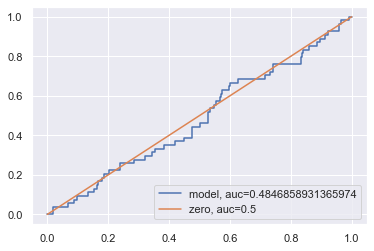

In [371]:
fpr, tpr, _ = metrics.roc_curve(targs, preds)
auc = metrics.roc_auc_score(targs, preds)
plt.plot(fpr,tpr,label="model, auc="+str(auc))

fpr, tpr, _ = metrics.roc_curve(targs, np.zeros_like(targs))
auc = metrics.roc_auc_score(targs, np.zeros_like(targs))
plt.plot(fpr,tpr,label="zero, auc="+str(auc))

plt.legend(loc=4)
plt.show()